In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charging and discharging curve

We use the a datasheet from CS2_35 to explore the charging/discharging curve. We create three plots:

* Voltage and current VS testing time;
* Charing/discharing capacity and energy;
* The associated step indexes.

In [ ]:
dir_path = r'C:\Users\Zhiguo\OneDrive - CentraleSupelec\Code\Python\battery_calce\data\CS2_35\CS2_35_8_30_10.xlsx'
df = pd.read_excel(dir_path, sheet_name=1)
df.head()

In [ ]:
cycles = list(set(df['Cycle_Index']))
c = cycles[8]
df_cycle = df[df['Cycle_Index'] == c]

# Create the plot: Voltage and Current V.S. time.
fig = plt.figure(figsize=(8, 15))
ax_1 = fig.add_subplot(3,1,1)
ax_1.plot(df_cycle['Test_Time(s)']/3600, df_cycle['Voltage(V)'], 'ro-')
ax_1.set_xlabel('Test time (h)')
ax_1.set_ylabel('Voltage (V)')
ax_1.legend(['Voltage'])
ax_1_b = ax_1.twinx()
ax_1_b.plot(df_cycle['Test_Time(s)']/3600, df_cycle['Current(A)'], 'bo-')
ax_1_b.set_ylabel('Current (A)')
ax_1_b.legend(['Current'])

ax_2 = fig.add_subplot(3,1,2)
ax_2.plot(df_cycle['Test_Time(s)']/3600, df_cycle['Charge_Capacity(Ah)'], 'ro-')
ax_2.plot(df_cycle['Test_Time(s)']/3600, df_cycle['Discharge_Capacity(Ah)'], 'rd--')
ax_2.set_xlabel('Test time (h)')
ax_2.set_ylabel('Capacity (Ah)')
ax_2_b = ax_2.twinx()
ax_2_b.plot(df_cycle['Test_Time(s)']/3600, df_cycle['Charge_Energy(Wh)'], 'bo-')
ax_2_b.plot(df_cycle['Test_Time(s)']/3600, df_cycle['Discharge_Energy(Wh)'], 'bd--')
ax_2_b.set_ylabel('Energy (Wh)')

ax_3 = fig.add_subplot(3,1,3)
ax_3.plot(df_cycle['Test_Time(s)']/3600, df_cycle['Step_Index'], '-k')
ax_3.set_xlabel('Test_Time(h)')
ax_3.set_ylabel('Step_Index')

From the results, we can see that:
1. "All CS2 cells underwent the same charging profile which was a standard constant current/constant voltage protocol with a constant current rate of 0.5C until the voltage reached 4.2V and then 4.2V was sustained until the charging current dropped to below 0.05A. Unless specified, the discharge cut off voltage for these batteries was 2.7V."
2. So we start from a charging phase with constant current, and as charing goes, the voltage goes up until $4.2$ V. Then, the voltage keeps constant and the charging current drops. The charing finishes when the charging current drops below $0.05$ A. 
3. Then, the battery is discharged with a constant current of $-1$ C. That means it will take $1h$ to discharge the entire battery. As the battery discharges, the voltage drops until $2.7V$, which indicates the end of the discharging phase.
4. The meaning of step_index is not clear. But it seems that $2$ indicates the phase of constant current charging, while $4$ is constant voltage charging. $7$ is the constant current discharging phase.

Another important observation is that, although in the original data, we have charging and discharging capaciites, but it seems that the values are not correct. So it has to be calculated from charging/discharging current.

# Performance charateristics for different batteries.

We define a function in utility.py to load the different data sheet for a given battery. Here, we use this function to load all the test data for a given battery, and visualize the trend of the following performance indicators:

* charging capacity
* discharging capacity
* Constant Current Charging Time
* Constant Voltage Charging Time
* State of Health: Defined as the discharged capacity when the voltage drops from $3.8 V$ to $3.4 V$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utility import load_data
import pickle

battery_list = {'CS2_35', 'CS2_36', 'CS2_37', 'CS2_38'}

In [ ]:
# # Read data.
# dir_path = r'C:\Users\Zhiguo\OneDrive - CentraleSupelec\Code\Python\battery_calce\data\\'
# data_all = load_data(battery_list, dir_path)

# # Save to file.
# with open('data_all.pickle', 'wb') as f:
#     pickle.dump(data_all, f, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
# Directly read from the archived data.
with open('data_all.pickle', 'rb') as f:
    data_all = pickle.load(f)

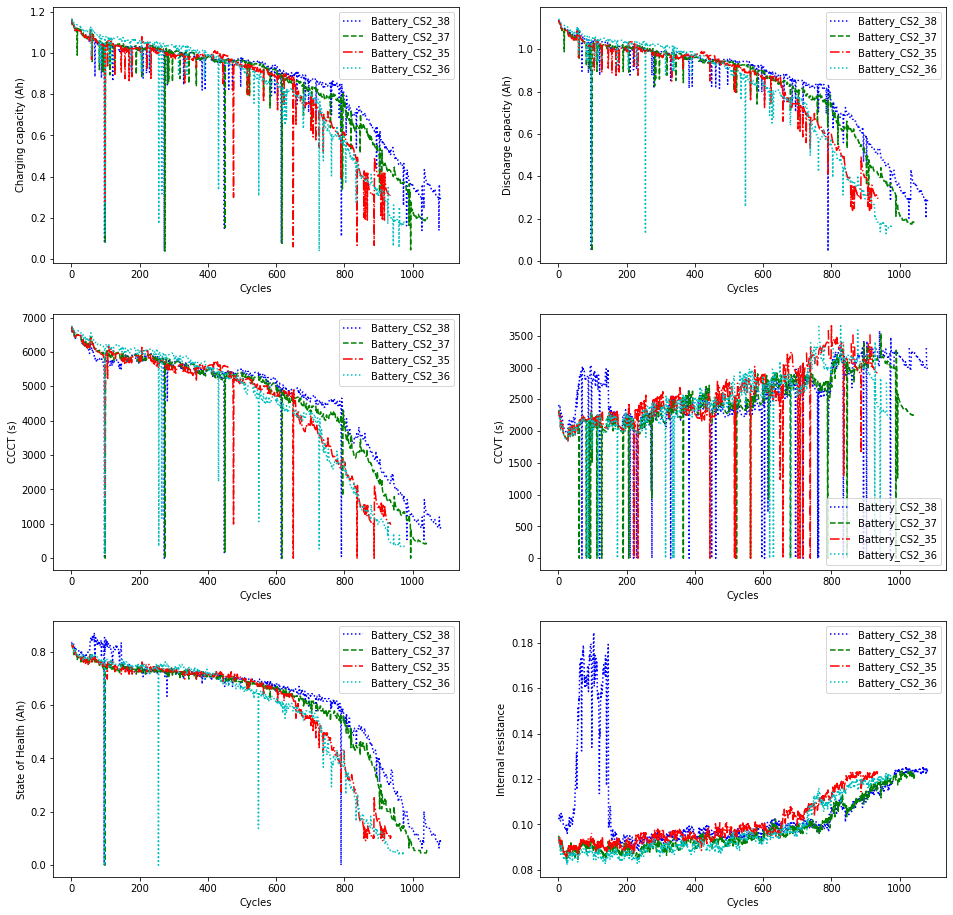

In [3]:
fig, axes = plt.subplots(3,2, figsize=(16, 16))
color_list = ['b:', 'g--', 'r-.', 'c:']
for name, color in zip(battery_list, color_list):
    battery = data_all[name]

    # Plot charging capacity.
    axes[0][0].plot(battery['cycle'], battery['charging capacity'], color, label='Battery_'+name)
    axes[0][0].set(xlabel='Cycles', ylabel='Charging capacity (Ah)')
    axes[0][0].legend()
    
    # Plot discharging capacity.
    axes[0][1].plot(battery['cycle'], battery['discharging capacity'], color, label='Battery_'+name)
    axes[0][1].set(xlabel='Cycles', ylabel='Discharge capacity (Ah)')
    axes[0][1].legend()

    # Plot CCCT.
    axes[1][0].plot(battery['cycle'], battery['CCCT'], color, label='Battery_'+name)
    axes[1][0].set(xlabel='Cycles', ylabel='CCCT (s)')
    axes[1][0].legend()

    # Plot CVCT.
    axes[1][1].plot(battery['cycle'], battery['CVCT'], color, label='Battery_'+name)
    axes[1][1].set(xlabel='Cycles', ylabel='CCVT (s)')
    axes[1][1].legend()

    # Plot SOH.
    axes[2][0].plot(battery['cycle'], battery['SoH'], color, label='Battery_'+name)
    axes[2][0].set(xlabel='Cycles', ylabel='State of Health (Ah)')
    axes[2][0].legend()

    # Plot internal resistance.
    axes[2][1].plot(battery['cycle'], battery['resistance'], color, label='Battery_'+name)
    axes[2][1].set(xlabel='Cycles', ylabel='Internal resistance')
    axes[2][1].legend()

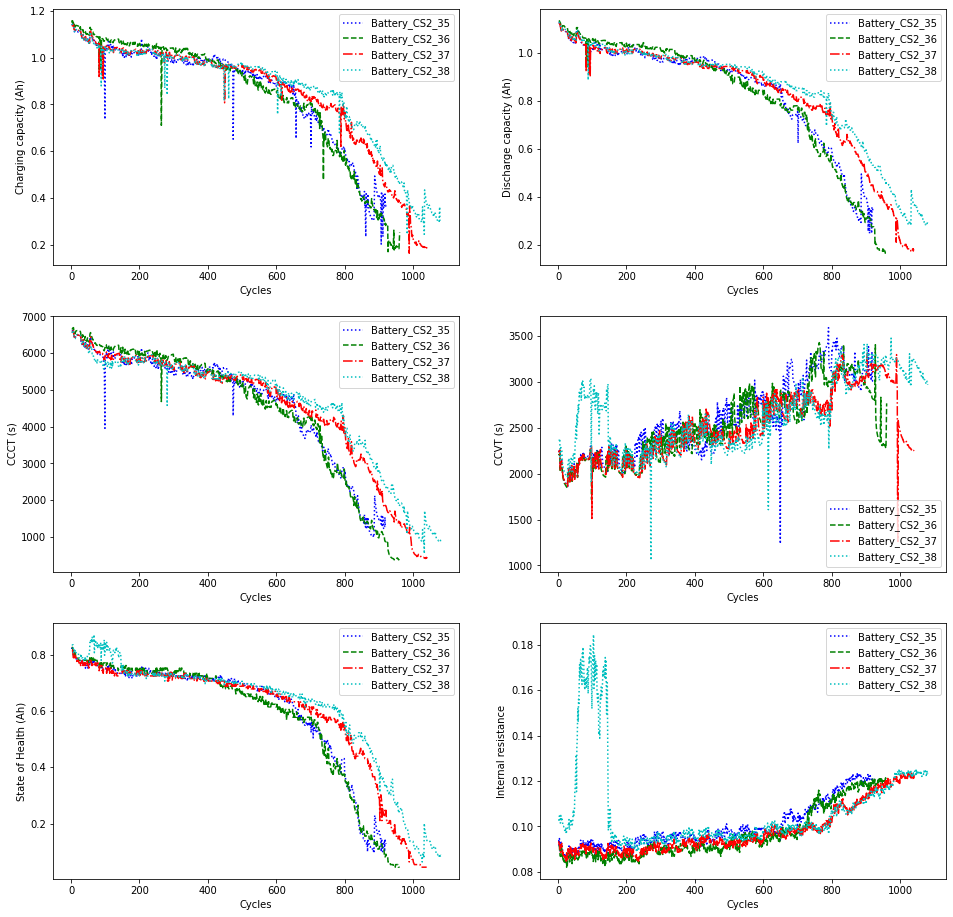

In [5]:
from utility import drop_outlier_rolling
from utility import drop_outlier_sw

fig, axes = plt.subplots(3,2, figsize=(16, 16))
color_list = ['b:', 'g--', 'r-.', 'c:']
for name, color in zip(battery_list, color_list):
    battery = data_all[name]
    rolling_window = 20

    # Plot charging capacity.
    x = battery['cycle']
    y = battery['charging capacity']
    # idx = drop_outlier_rolling(y, rolling_window)
    # y[idx] = np.nan
    idx = drop_outlier_sw(y, rolling_window)
    x = x[idx]
    y = y[idx]
    axes[0][0].plot(x, y, color, label='Battery_'+name)
    axes[0][0].set(xlabel='Cycles', ylabel='Charging capacity (Ah)')
    axes[0][0].legend()
    
    # Plot discharging capacity.
    x = battery['cycle']
    y = battery['discharging capacity']
    idx = drop_outlier_sw(y, rolling_window)
    x = x[idx]
    y = y[idx]
    axes[0][1].plot(x, y, color, label='Battery_'+name)
    axes[0][1].set(xlabel='Cycles', ylabel='Discharge capacity (Ah)')
    axes[0][1].legend()

    # Plot CCCT.
    x = battery['cycle']
    y = battery['CCCT']
    idx = drop_outlier_sw(y, rolling_window)
    x = x[idx]
    y = y[idx]
    axes[1][0].plot(x, y, color, label='Battery_'+name)
    axes[1][0].set(xlabel='Cycles', ylabel='CCCT (s)')
    axes[1][0].legend()

    # Plot CVCT.
    x = battery['cycle']
    y = battery['CVCT']
    idx = drop_outlier_sw(y, rolling_window)
    x = x[idx]
    y = y[idx]
    axes[1][1].plot(x, y, color, label='Battery_'+name)
    axes[1][1].set(xlabel='Cycles', ylabel='CCVT (s)')
    axes[1][1].legend()

    # Plot SOH.
    x = battery['cycle']
    y = battery['SoH']
    idx = drop_outlier_sw(y, rolling_window)
    x = x[idx]
    y = y[idx]
    axes[2][0].plot(x, y, color, label='Battery_'+name)
    axes[2][0].set(xlabel='Cycles', ylabel='State of Health (Ah)')
    axes[2][0].legend()

    # Plot internal resistance.
    x = battery['cycle']
    y = battery['resistance']
    idx = drop_outlier_sw(y, rolling_window)
    x = x[idx]
    y = y[idx]
    axes[2][1].plot(x, y, color, label='Battery_'+name)
    axes[2][1].set(xlabel='Cycles', ylabel='Internal resistance')
    axes[2][1].legend()

In [6]:
from utility import cal_ttf

ttf_all = []
for name in battery_list:
    battery = data_all[name]
    x = battery['cycle']
    y = battery['discharging capacity']
    idx = drop_outlier_sw(y, 20)
    x = x[idx]
    y = y[idx]

    ttf = cal_ttf(x, y, .7*1.1)
    ttf_all.append(ttf)